# LSTM EFAS5: analizar la red
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 25-09-2023*<br>

**Introducción:**<br>
En este _notebook_ se analizan la red entrenada en el modelo LSTM que replica el caudal simulado en EFAS5 a partir de las series meteorológicas de EMO1 y los atributos estáticos derivados de los mapas estáticos de LISFLOOD y los parámetros calibrados del modelo LISFLOOD.

**Por hacer**:

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [2]:
from neuralhydrology.evaluation import metrics
from torch.utils.data import DataLoader

from neuralhydrology.datasetzoo import get_dataset, genericdataset, camelsus
from neuralhydrology.evaluation.utils import load_scaler
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.modelzoo.customlstm import CustomLSTM
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

In [24]:
# definir experimento y simulación
run = 'EFAS_test3_2609_093820'
run_dir = Path(f'runs/{run}')
config_file = Path(run_dir / 'config.yml')

In [25]:
# config_file = Path('config.yml')
# run_dir = Path("runs/EFAS_2008_153350")

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=config_file)

# fall back to CPU-only mode
else:
    start_run(config_file=config_file, gpu=-1)

2023-09-30 12:58:38,519: Logging to \content\drive\MyDrive\TFM\notebook\models\EFAS5\runs\EFAS_test3_2609_093820\EFAS_test3_3009_125838\output.log initialized.
2023-09-30 12:58:38,520: ### Folder structure created at \content\drive\MyDrive\TFM\notebook\models\EFAS5\runs\EFAS_test3_2609_093820\EFAS_test3_3009_125838
2023-09-30 12:58:38,521: ### Run configurations for EFAS_test3
2023-09-30 12:58:38,522: batch_size: 256
2023-09-30 12:58:38,523: clip_gradient_norm: 0.8
2023-09-30 12:58:38,525: clip_targets_to_zero: ['dis_efas5']
2023-09-30 12:58:38,526: commit_hash: None
2023-09-30 12:58:38,527: data_dir: ..\..\..\data\CAMELS-ES
2023-09-30 12:58:38,528: dataset: generic
2023-09-30 12:58:38,528: device: cpu
2023-09-30 12:58:38,529: dynamic_inputs: ['pr_emo1', 'ta_emo1', 'e0_emo1']
2023-09-30 12:58:38,531: epochs: 50
2023-09-30 12:58:38,532: experiment_name: EFAS_test3
2023-09-30 12:58:38,533: head: regression
2023-09-30 12:58:38,534: hidden_size: 128
2023-09-30 12:58:38,535: img_log_dir: \c

### Modelo

In [ ]:
# cargar archivo de configuración
config = Config(config_file)

In [ ]:
# cargar los pesos del modelo entrenado
model_path = run_dir / f'model_epoch{config.epochs:03}.pt'
model_weights = torch.load(str(model_path), map_location='cpu')  # load the weights from the file, creating the weight tensors on CPU

**CudaLSTM**

In [ ]:
# crear un nuevo modelo CudaLSTM con pesos aleatorios
cuda_lstm = CudaLSTM(cfg=config)

# asignar los pesos del modelo entrenado
cuda_lstm.load_state_dict(model_weights)
cuda_lstm

**CustomLSTM**

In [ ]:
# crear un nuevo CustomLSTM con pesos aleatorios
custom_lstm = CustomLSTM(cfg=config)

# copiar los pesos del modelo entrenado
custom_lstm.copy_weights(cuda_lstm)  
custom_lstm

In [22]:
torch.allclose(cuda_lstm.lstm.bias_ih_l0, custom_lstm.cell.b_ih)

True

In [23]:
# make sure we're in eval mode where dropout is deactivated
custom_lstm.eval()
cuda_lstm.eval()

# load the dataset
scaler = load_scaler(run_dir)
dataset = get_dataset(config, is_train=False, period='test', scaler=scaler)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=False, collate_fn=dataset.collate_fn)

cudalstm_output = []
customlstm_output = []
# no need to calculate any gradients since we're just running some evaluations
with torch.no_grad():
    for sample in tqdm(dataloader):
        customlstm_output.append(custom_lstm(sample))
        cudalstm_output.append(cuda_lstm(sample))

print('CudaLSTM output:  ', list(cudalstm_output[0].keys()))
print('CustomLSTM output:', list(customlstm_output[0].keys()))

# check if predictions of CustomLSTM and CudaLSTM are identical
print('Identical predictions:', torch.allclose(customlstm_output[0]['y_hat'], cudalstm_output[0]['y_hat'], atol=1e-5))

  0%|          | 0/542 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x56 and 52x512)

In [11]:
print('CudaLSTM shape:  ', cudalstm_output[0]['c_n'].shape)  # [batch size, 1, hidden size]
print('CustomLSTM shape:', customlstm_output[0]['c_n'].shape)  # [batch size, sequence length, hidden size]

CudaLSTM shape:   torch.Size([1000, 1, 128])
CustomLSTM shape: torch.Size([1000, 365, 128])


In [12]:
print('CudaLSTM shape:  ', cudalstm_output[1]['c_n'].shape)  # [batch size, 1, hidden size]
print('CustomLSTM shape:', customlstm_output[1]['c_n'].shape)  # [batch size, sequence length, hidden size]

CudaLSTM shape:   torch.Size([1000, 1, 128])
CustomLSTM shape: torch.Size([1000, 365, 128])


In [13]:
len(customlstm_output)

7

In [14]:
# Concatenate all batches into one tensor that contains the final time step of each sample.
cell_states = torch.cat([out['c_n'][:, -1, :] for out in customlstm_output], dim=0)

# Load the forcings input for the corresponding date range
date_range = pd.date_range(config.test_start_date, config.test_end_date, freq='1D')

In [15]:
config.data_dir

WindowsPath('../../../data/CAMELS-ESP')

In [30]:
forcings = genericdataset.load_timeseries(config.data_dir, '1620').loc[date_range, config.dynamic_inputs]

ValueError: x and y must have same first dimension, but have shapes (1096,) and torch.Size([6576, 128])

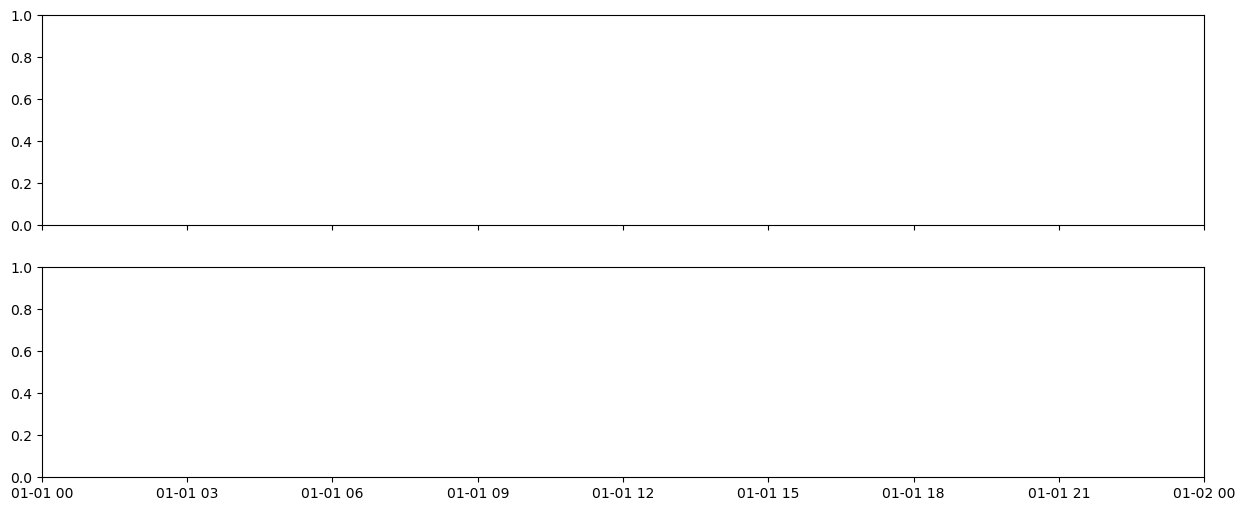

In [35]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax.plot(date_range, cell_states, c='C0', alpha=.2)
ax.plot(date_range, cell_states[:, 7], c='C0')

ax.set_ylabel('cell state')
ax2.set_ylabel('min/max temperature')

ax2.plot(date_range, forcings['tmin(C)'], c='C1')
ax2.plot(date_range, forcings['tmax(C)'], c='C2')
plt.tight_layout()

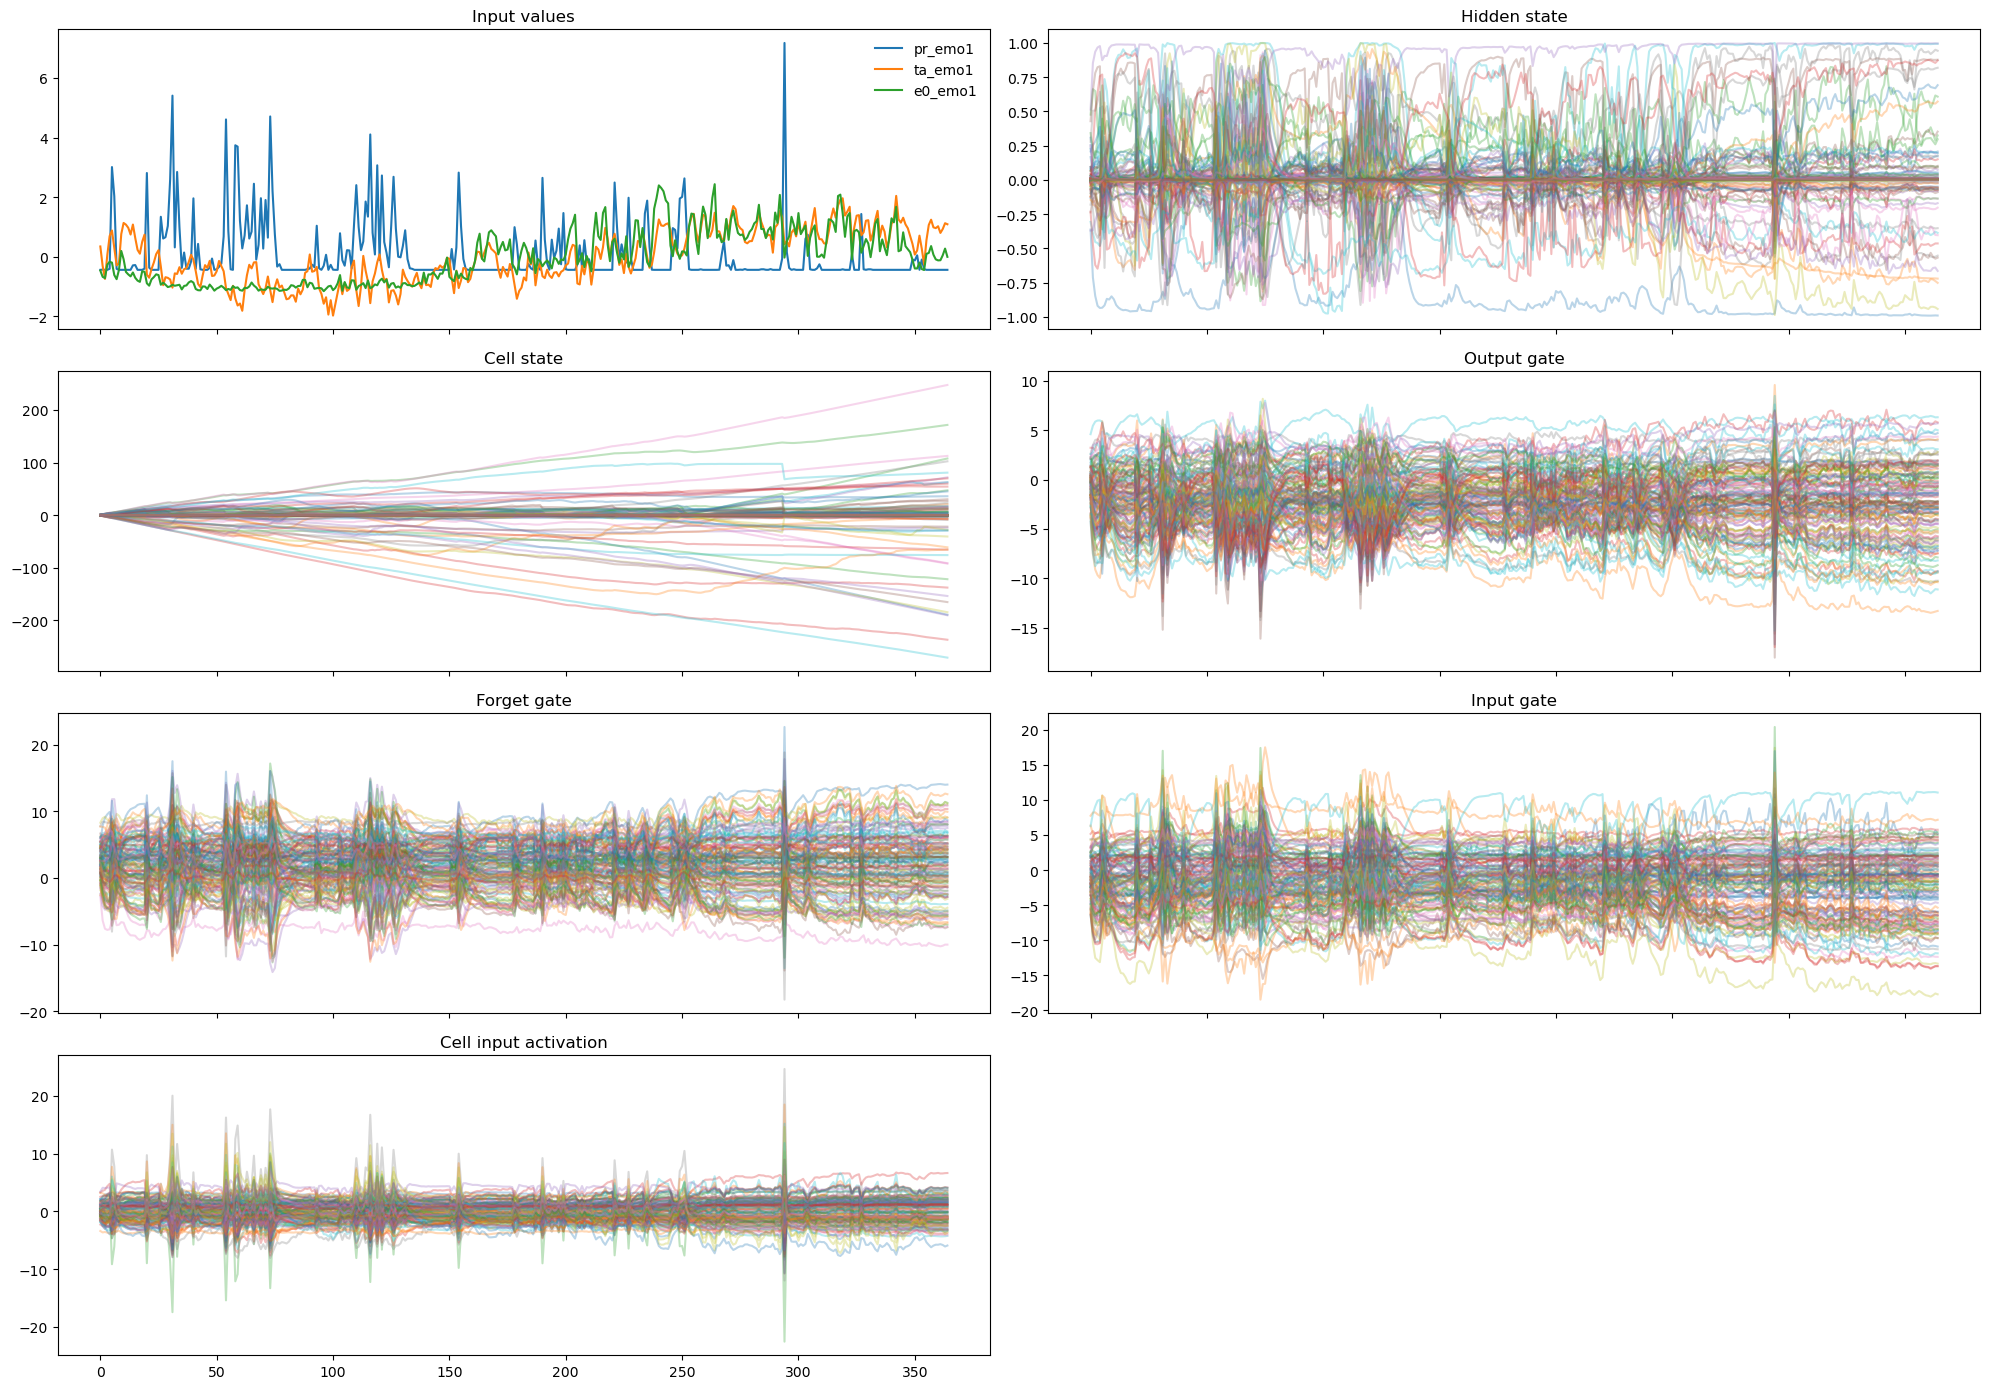

In [36]:
f, ax = plt.subplots(4, 2, figsize=(20, 14), sharex=True)
ax[0,0].set_title('Input values')
lines = ax[0,0].plot(dataset[0]['x_d'])  # these are the normalized inputs we fed the LSTM above
ax[0,0].legend(lines, config.dynamic_inputs, frameon=False)

ax[1,0].set_title('Cell state')
ax[1,0].plot(customlstm_output[0]['c_n'][0], alpha=.3)

ax[0,1].set_title('Hidden state')
ax[0,1].plot(customlstm_output[0]['h_n'][0], alpha=.3)

ax[1,1].set_title('Output gate')
ax[1,1].plot(customlstm_output[0]['o'][0], alpha=.3)

ax[2,0].set_title('Forget gate')
ax[2,0].plot(customlstm_output[0]['f'][0], alpha=.3)

ax[2,1].set_title('Input gate')
ax[2,1].plot(customlstm_output[0]['i'][0], alpha=.3)

ax[3,0].set_title('Cell input activation')
ax[3,0].plot(customlstm_output[0]['g'][0], alpha=.3)

f.delaxes(ax[3,1])
plt.tight_layout()

### Optimizador

In [33]:
optimizer = torch.load(run_dir / f'optimizer_state_epoch{config.epochs:03}.pt', map_location=torch.device('cpu'))

In [ ]:
optimizer.keys()

In [ ]:
optimizer['state']